In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

## Load the dataset

In [2]:
# URL of the dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv'

# Load the dataset
df = pd.read_csv(url)

# Display the first few rows of the dataset
print(df.head())

   X  Y month  day  FFMC   DMC     DC  ISI  temp  RH  wind  rain  area
0  7  5   mar  fri  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0   0.0
1  7  4   oct  tue  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0   0.0
2  7  4   oct  sat  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0   0.0
3  8  6   mar  fri  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2   0.0
4  8  6   mar  sun  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0   0.0


## Data cleaning

Convert non-numeric values to numeric

In [3]:
# Convert categorical variables to numeric
df['month'] = pd.Categorical(df['month']).codes
df['day'] = pd.Categorical(df['day']).codes

## Remove the target from the dataset

In [4]:
# Separate features and target
X = df.drop(['area'], axis=1)
y = df['area']

In [5]:
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Lasso': Lasso(alpha=0.1),
    'Ridge': Ridge(alpha=0.1),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5)
}

# Function to calculate RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

print("1. Using KFold Cross Validation")
print("-" * 50)

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    rmse_scores = []
    
    for train_idx, test_idx in kf.split(X_scaled):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse_scores.append(rmse(y_test, y_pred))
    
    print(f"{name} - Mean RMSE: {np.mean(rmse_scores):.4f} (±{np.std(rmse_scores):.4f})")

print("\n2. Using cross_val_predict()")
print("-" * 50)

for name, model in models.items():
    y_pred = cross_val_predict(model, X_scaled, y, cv=5)
    score = rmse(y, y_pred)
    print(f"{name} - RMSE: {score:.4f}")

print("\n3. Using cross_val_score()")
print("-" * 50)

for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=5, scoring='neg_root_mean_squared_error')
    print(f"{name} - Mean RMSE: {-scores.mean():.4f} (±{scores.std():.4f})")

# Analysis of feature importance using Lasso
print("\n4. Feature Importance Analysis using Lasso")
print("-" * 50)

lasso = Lasso(alpha=0.1)
lasso.fit(X_scaled, y)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lasso.coef_
})
print("Feature importance (sorted by absolute value):")
print(feature_importance.reindex(feature_importance['Coefficient'].abs().sort_values(ascending=False).index))

# Refined models based on insights
print("\n5. Refined Models")
print("-" * 50)

# Get important features (non-zero coefficients from Lasso)
important_features = feature_importance[feature_importance['Coefficient'] != 0]['Feature'].tolist()
X_important = X_scaled[:, [list(X.columns).index(feat) for feat in important_features]]

for name, model in models.items():
    scores = cross_val_score(model, X_important, y, cv=5, scoring='neg_root_mean_squared_error')
    print(f"{name} (Important Features) - Mean RMSE: {-scores.mean():.4f} (±{scores.std():.4f})")

# Grid Search for best alpha values
from sklearn.model_selection import GridSearchCV

print("\n6. Hyperparameter Tuning")
print("-" * 50)

# Define parameter grids
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]
}

for name in ['Lasso', 'Ridge', 'ElasticNet']:
    if name == 'ElasticNet':
        param_grid['l1_ratio'] = [0.1, 0.3, 0.5, 0.7, 0.9]
    
    model = models[name]
    grid_search = GridSearchCV(
        model, param_grid, cv=5, 
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )
    
    grid_search.fit(X_important, y)
    
    print(f"\nBest parameters for {name}:")
    print(grid_search.best_params_)
    print(f"Best RMSE: {-grid_search.best_score_:.4f}")

1. Using KFold Cross Validation
--------------------------------------------------
Linear Regression - Mean RMSE: 54.7534 (±32.4435)
Lasso - Mean RMSE: 54.5803 (±32.6081)
Ridge - Mean RMSE: 54.7506 (±32.4457)
ElasticNet - Mean RMSE: 54.3591 (±32.7882)

2. Using cross_val_predict()
--------------------------------------------------
Linear Regression - RMSE: 64.6934
Lasso - RMSE: 64.6106
Ridge - RMSE: 64.6920
ElasticNet - RMSE: 64.5595

3. Using cross_val_score()
--------------------------------------------------
Linear Regression - Mean RMSE: 51.1926 (±39.7447)
Lasso - Mean RMSE: 51.0418 (±39.8035)
Ridge - Mean RMSE: 51.1905 (±39.7450)
ElasticNet - Mean RMSE: 50.8793 (±39.9288)

4. Feature Importance Analysis using Lasso
--------------------------------------------------
Feature importance (sorted by absolute value):
   Feature  Coefficient
5      DMC     6.483516
8     temp     5.394831
0        X     4.247705
2    month     3.901202
6       DC    -3.065246
10    wind     3.010238
9   

1. Initial Data Loading and Analysis
--------------------------------------------------

Dataset Shape: (517, 13)

Data Types:
 X          int64
Y          int64
month     object
day       object
FFMC     float64
DMC      float64
DC       float64
ISI      float64
temp     float64
RH         int64
wind     float64
rain     float64
area     float64
dtype: object

Missing Values:
 X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64

Numerical Features Summary:
                 X           Y        FFMC         DMC          DC         ISI  \
count  517.000000  517.000000  517.000000  517.000000  517.000000  517.000000   
mean     4.669246    4.299807   90.644681  110.872340  547.940039    9.021663   
std      2.313778    1.229900    5.520111   64.046482  248.066192    4.559477   
min      1.000000    2.000000   18.700000    1.100000    7.900000    0.000000   
25%      3.000000    4.00000

<Figure size 1500x1000 with 0 Axes>

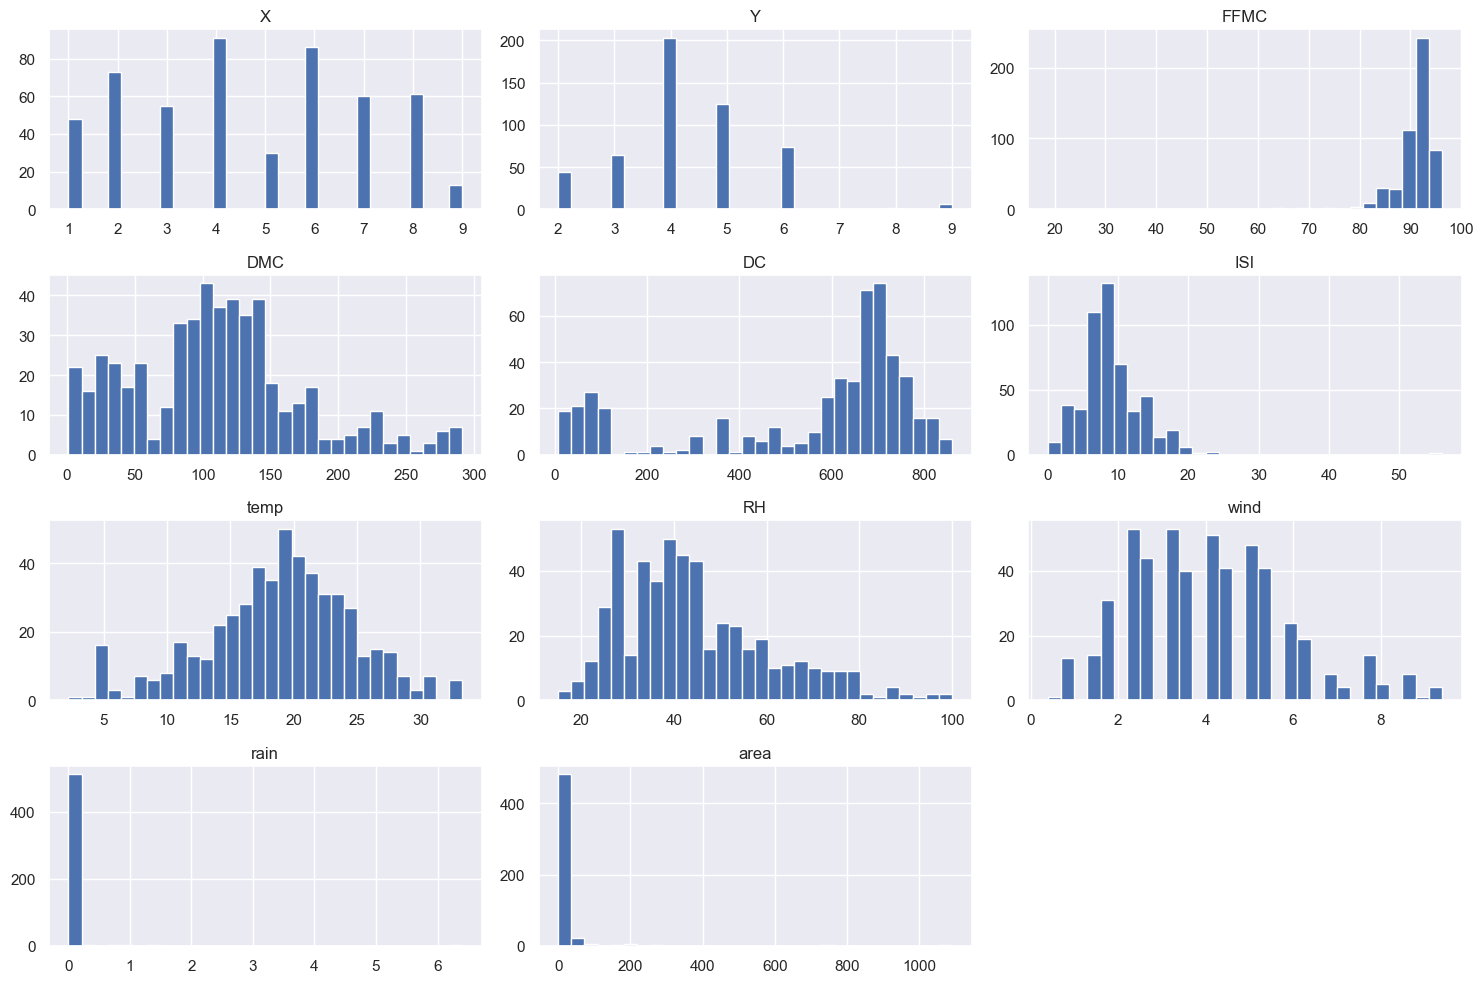


2. Handling Categorical Variables
--------------------------------------------------

3. Handling Outliers
--------------------------------------------------

4. Feature Transformation
--------------------------------------------------

5. Feature Scaling
--------------------------------------------------

6. Final Dataset Preparation
--------------------------------------------------

Final dataset shape: (517, 17)
Number of features: 17

7. Model Training and Evaluation
--------------------------------------------------

Linear Regression:
Mean RMSE: 0.9989
Std RMSE: 0.0402

Lasso:
Mean RMSE: 0.9957
Std RMSE: 0.0398

Ridge:
Mean RMSE: 0.9988
Std RMSE: 0.0401

ElasticNet:
Mean RMSE: 0.9931
Std RMSE: 0.0377

Analysis completed successfully!


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro
from scipy import stats

# Set plot style using Seaborn
sns.set(style='darkgrid')

def load_and_analyze_data():
    """Load data and perform initial analysis"""
    print("1. Initial Data Loading and Analysis")
    print("-" * 50)
    
    # URL of the dataset
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv'

    try:
        # Load the dataset
        df = pd.read_csv(url)
        
        # Identify numeric columns
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        
        # Convert numeric columns to float64
        for col in numeric_cols:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # Initial analysis
        print("\nDataset Shape:", df.shape)
        print("\nData Types:\n", df.dtypes)
        print("\nMissing Values:\n", df.isnull().sum())
        print("\nNumerical Features Summary:\n", df.describe())
        
        # Plot initial distributions
        plt.figure(figsize=(15, 10))
        df[numeric_cols].hist(bins=30, figsize=(15, 10))
        plt.tight_layout()
        plt.title("Initial Feature Distributions")
        plt.show()
        
        return df
        
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

def handle_categorical_variables(df):
    """Process categorical variables"""
    print("\n2. Handling Categorical Variables")
    print("-" * 50)
    
    try:
        df = df.copy()
        
        # Convert month to numeric
        month_map = {
            'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
            'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
        }
        df['month'] = df['month'].map(month_map).astype(float)
        
        # Convert day to numeric
        day_map = {
            'mon': 1, 'tue': 2, 'wed': 3, 'thu': 4, 
            'fri': 5, 'sat': 6, 'sun': 7
        }
        df['day'] = df['day'].map(day_map).astype(float)
        
        # Create weekend indicator
        df['is_weekend'] = ((df['day'] >= 6) & (df['day'] <= 7)).astype(float)
        
        # Create seasons
        df['season'] = pd.cut(
            df['month'],
            bins=[0, 3, 6, 9, 12],
            labels=['winter', 'spring', 'summer', 'fall'],
            include_lowest=True
        )
        
        # Convert seasons to dummy variables
        season_dummies = pd.get_dummies(df['season'], prefix='season')
        df = pd.concat([df, season_dummies], axis=1)
        df.drop(['season'], axis=1, inplace=True)
        
        return df
        
    except Exception as e:
        print(f"Error processing categorical variables: {e}")
        return None

def handle_outliers(df):
    """Handle outliers using winsorization"""
    print("\n3. Handling Outliers")
    print("-" * 50)
    
    try:
        df_clean = df.copy()
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        
        for col in numeric_cols:
            # Convert to numeric and handle non-finite values
            series = pd.to_numeric(df_clean[col], errors='coerce')
            
            # Only process if we have valid numeric data
            if not series.empty and series.notna().any():
                # Calculate quantiles
                q1 = series.quantile(0.25)
                q3 = series.quantile(0.75)
                iqr = q3 - q1
                
                # Define bounds
                lower_bound = q1 - 1.5 * iqr
                upper_bound = q3 + 1.5 * iqr
                
                # Winsorize the data
                series = series.clip(lower=lower_bound, upper=upper_bound)
                
                # Update the column
                df_clean[col] = series
        
        return df_clean
        
    except Exception as e:
        print(f"Error handling outliers: {e}")
        return None

def transform_features(df):
    """Transform features for better distribution"""
    print("\n4. Feature Transformation")
    print("-" * 50)
    
    try:
        df_transformed = df.copy()
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        
        # Log transform the target variable (area)
        df_transformed['area'] = np.log1p(df_transformed['area'].astype(float))
        
        # Apply Yeo-Johnson transformation to other numeric features
        pt = PowerTransformer(method='yeo-johnson', standardize=False)
        numeric_cols_to_transform = [col for col in numeric_cols if col != 'area']
        
        if numeric_cols_to_transform:
            # Convert to float and handle non-finite values
            data_to_transform = df_transformed[numeric_cols_to_transform].astype(float)
            data_to_transform = data_to_transform.replace([np.inf, -np.inf], np.nan)
            data_to_transform = data_to_transform.fillna(data_to_transform.mean())
            
            # Apply transformation
            transformed_data = pt.fit_transform(data_to_transform)
            df_transformed[numeric_cols_to_transform] = transformed_data
        
        return df_transformed
        
    except Exception as e:
        print(f"Error transforming features: {e}")
        return None

def scale_features(df):
    """Scale features"""
    print("\n5. Feature Scaling")
    print("-" * 50)
    
    try:
        df_scaled = df.copy()
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        
        # Initialize scaler
        scaler = StandardScaler()
        
        # Convert to float and handle non-finite values
        data_to_scale = df_scaled[numeric_cols].astype(float)
        data_to_scale = data_to_scale.replace([np.inf, -np.inf], np.nan)
        data_to_scale = data_to_scale.fillna(data_to_scale.mean())
        
        # Scale features
        scaled_data = scaler.fit_transform(data_to_scale)
        df_scaled[numeric_cols] = scaled_data
        
        return df_scaled
        
    except Exception as e:
        print(f"Error scaling features: {e}")
        return None

def prepare_final_dataset(df):
    """Prepare final dataset"""
    print("\n6. Final Dataset Preparation")
    print("-" * 50)
    
    try:
        # Ensure all numeric columns are float
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # Handle any remaining missing values
        df = df.fillna(df.mean())
        
        # Separate features and target
        X = df.drop('area', axis=1)
        y = df['area']
        
        # Convert to numpy arrays
        X = X.astype(float).values
        y = y.astype(float).values
        
        print("\nFinal dataset shape:", X.shape)
        print("Number of features:", X.shape[1])
        
        return X, y
        
    except Exception as e:
        print(f"Error preparing final dataset: {e}")
        return None, None

def train_and_evaluate_models(X, y):
    """Train and evaluate models"""
    print("\n7. Model Training and Evaluation")
    print("-" * 50)
    
    try:
        # Initialize models
        models = {
            'Linear Regression': LinearRegression(),
            'Lasso': Lasso(alpha=0.1),
            'Ridge': Ridge(alpha=0.1),
            'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5)
        }
        
        # Initialize KFold
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        
        results = {}
        for name, model in models.items():
            # Perform cross-validation
            cv_scores = cross_val_score(
                model, X, y,
                cv=kf,
                scoring='neg_mean_squared_error'
            )
            
            rmse_scores = np.sqrt(-cv_scores)
            
            results[name] = {
                'mean_rmse': rmse_scores.mean(),
                'std_rmse': rmse_scores.std()
            }
            
            print(f"\n{name}:")
            print(f"Mean RMSE: {results[name]['mean_rmse']:.4f}")
            print(f"Std RMSE: {results[name]['std_rmse']:.4f}")
        
        return results
        
    except Exception as e:
        print(f"Error training and evaluating models: {e}")
        return None

def main():
    """Main execution pipeline"""
    # Load data
    df = load_and_analyze_data()
    if df is None:
        return
    
    # Process categorical variables
    df = handle_categorical_variables(df)
    if df is None:
        return
    
    # Handle outliers
    df = handle_outliers(df)
    if df is None:
        return
    
    # Transform features
    df = transform_features(df)
    if df is None:
        return
    
    # Scale features
    df = scale_features(df)
    if df is None:
        return
    
    # Prepare final dataset
    X, y = prepare_final_dataset(df)
    if X is None or y is None:
        return
    
    # Train and evaluate models
    results = train_and_evaluate_models(X, y)
    if results is None:
        return
    
    print("\nAnalysis completed successfully!")
    return X, y, results

if __name__ == "__main__":
    X, y, results = main()